# <div style="text-align: center">18.335/6.337 Final Project - The L-BFGS algorithm</div>
##  <div style="text-align: center">Strong Wolfe Line-Search</div>
### <div style="text-align: center">Created by Yusu Liu and Simon Batzner</div>

## Import test functions and set up environment

In [1]:
function lbfgs!(F, x0, maxIt, m, save_pos = 0, τgrad=1e-8, verbose = 0)
    #INPUT
    # F: function to be optimized
    # x0: initial guess
    # maxIt: maximum Iteration
    # m: last m input differences and gradient differences are stored
    # τgrad: tolerance for norm of the slope


    #OUTPUT
    #x1: optimized variable
    #f1: function value at x1
    #k iteration number
    pos = zeros(maxIt, 2)
    k=0
    n=length(x0)
    Sm=zeros(n,m) #S_k=x_k+1-x_k
    Ym=zeros(n,m) #Y_k=g_k+1-g_k

    f0,g0=F(x0)
    #use the simplest line search to find step size
    α, f1, g1=strongwolfe(F,-g0,x0,f0,g0)
    x1 = x0 - α.*g0
    k=1
    if save_pos == 1
        pos[1, :] = x0
        pos[2, :] = x1
    end

    while true
        if k>maxIt
           break
        end
        gnorm=norm(g0)
        if gnorm < τgrad
           break
        end
        s0=x1-x0
        y0=g1-g0
        #println("y0=$y0")

        H0=s0'*y0/(y0'*y0) #hessian diagonal satisfying secant condition
        # println(H0)
        # if H0<0
        #     H0=1
        # end
        # println(H0)
        #update Sm and Ym
        if k<=m
           Sm[:,k]=s0
           Ym[:,k]=y0
           p=-approxInvHess(g1,Sm[:,1:k],Ym[:,1:k],H0)
        # only keep m entries in Sm and Ym so purge the old ones
        elseif (k>m)
           Sm[:,1:(m-1)]=Sm[:,2:m]
           Ym[:,1:(m-1)]=Sm[:,2:m]
           Sm[:,m]=s0
           Ym[:,m]=y0
           p=-approxInvHess(g1,Sm,Ym,H0)
        end
        # new direction=p, find new step size
        α, fs, gs=strongwolfe(F,p,x1,f1,g1)
        #update for next iteration
        x0=x1
        g0=g1
        x1=x1+α.*p

        if save_pos == 1
            pos[k+1, :] = x1
        end
        f1=fs
        g1=gs
        k=k+1

        if verbose == 1
           println("It=$k,x=$x1")
        end
    end

    k=k-1
    return x1, f1, k, pos
end

lbfgs! (generic function with 4 methods)

In [2]:
function strongwolfe(F,d,x0,fx0,gx0,maxIt=100)
   α_m=20
   α_p=0
   c1=1e-4
   c2=0.9
   α_x=1
   gx0=copy(gx0'*d)
   fxp=copy(fx0)
   gxp=copy(gx0)
   i=1
   α_s=0
   fs=copy(fx0)
   gs=copy(gx0)
   while true
       xx=x0+α_x*d
       fxx,gxx=F(xx)
       fs=copy(fxx)
       gs=copy(gxx)
       gxx=copy(gxx'*d)

       if (fxx>(fx0+c1*α_x*gx0)[1]) || (i>1) & (fxx>=fxp)
           α_s,fs,gs=zoom(F,x0,d,α_p,α_x,fx0,gx0)
           return α_s,fs,gs
       end
       if abs(gxx)<=-c2*(gx0)
           α_s=copy(α_x)
           return α_s,fs,gs
       end
       if gxx>=0
       #if abs.(gxx)[1]>=0 && abs.(gxx)[2]>=0
           α_s,fs,gs=zoom(F,x0,d,α_x,α_p,fx0,gx0)
           return α_s,fs,gs
       end
       α_p=copy(α_x)
       fxp=copy(fxx)
       gxp=copy(gxx)

       if i>maxIt
           α_s=α_x
           return α_s,fs,gs

       end
       r=0.8
       #r=0.8
       α_x=α_x+(α_m-α_x)*r
       i=i+1

   end
   return α_s,fs,gs
end

strongwolfe (generic function with 2 methods)

In [3]:
function zoom(F,x0,d,α_l,α_h,fx0,gx0,maxIt=10)
   c1=1e-4
   c2=0.9
   i=0
   α_s=0
   fs=copy(fx0)
   gs=copy(gx0)
   while true
       α_x=0.5*(α_l+α_h)
       α_s=copy(α_x)
       xx=x0+α_x*d
       fxx,gxx=F(xx)
       fs=copy(fxx)
       gs=copy(gxx)
       gxx=gxx'*d
       xl=x0+α_l*d
       fxl,gxl=F(xl)
       if (fxx>(fx0+c1*α_x*gx0)[1]) || fxx>=fxl
           α_h=copy(α_x)
       else
           if abs(gxx)[1]<=-c2*(gx0)
               α_s=copy(α_x)
               return α_s,fs,gs
           end
           if gxx*(α_h-α_l)[1]>=0
               α_h=copy(α_l)
           end
           α_l=copy(α_x)
       end
       i=i+1
       if i>maxIt
           α_s=copy(α_x)
           return α_s,fs,gs
       end
   end

   return α_s,fs,gs
end

zoom (generic function with 2 methods)

In [4]:
function approxInvHess(g,S,Y,H0,n=2)
    #INPUT

    #g: gradient nx1 vector
    #S: nxk matrixs storing S[i]=x[i+1]-x[i]
    #Y: nxk matrixs storing Y[i]=g[i+1]-g[i]
    #H0: initial hessian diagnol scalar

    #OUTPUT
    # p:  the approximate inverse hessian multiplied by the gradient g
    #     which is the new direction
    #notation follows:
    #https://en.wikipedia.org/wiki/Limited-memory_BFGS

    n,k=size(S)
    rho=zeros(k)
    for i=1:k
        rho[i].=abs(1/(Y[:,i]'*S[:,i]))
    end


    q=zeros(n,k+1)
    r=zeros(n,1)
    α=zeros(k,1)
    β=zeros(k,1)

    q[:,k+1]=g

    for i=k:-1:1
        α[i].=rho[i]*S[:,i]'*q[:,i+1]
        q[:,i].=q[:,i+1]-α[i]*Y[:,i]
    end

    z=zeros(n)
    z.=H0*q[:,1]


    for i=1:k
        β[i].=rho[i]*Y[:,i]'*z
        z.=z+S[:,i]*(α[i]-β[i])
    end

    p=copy(z)

    return p
end

approxInvHess (generic function with 2 methods)

## Define Functions and intervals to scan over

In [5]:
function test_range(fun, step, tol, m, τgrad)
    
    if fun == rosenbrock
        x1_opt = [1.0, 1.0]
        a0 = -2.048
        a1 = 2.048
        b0 = -2.048
        b1 = 2.048
        println("Scanning from $(a0) to $(a1) and from $(b0) to $(b1) for $(fun) function...")
        
    elseif fun == himmelblau
        
        # himmelblau function has 4 identical local minima
        x1_opt_array = [[3, 2], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584428, -1.848126]]
        a0 = -10
        a1 = 10
        b0 = -10
        b1 = 10
        println("Scanning from $(a0) to $(a1) and from $(b0) to $(b1) for $(fun) function...")
    

    elseif fun == booth
        x1_opt = [1.0, 3.0]
        a0 = -10
        a1 = 10
        b0 = -10
        b1 = 10
        println("Scanning from $(a0) to $(a1) and from $(b0) to $(b1) for $(fun) function...")
        
        
    else 
        println("ERORR: provide proper test function.")
        
    end
    
    cnt = 0
    n = 0
    
    for a in a0:step:a1
        for b in b0:step:b1
            
            n += 1 
            x0 = [a, b]
            x1, f1, k = lbfgs!(fun, x0, 100, m, τgrad); 
            
            # himmelblau test function
            if fun == himmelblau
                f_him = 0
                
                for i = 1:4
                    x1_opt = x1_opt_array[i, :]
                    if (norm(x1 - x1_opt[1])) < tol
                        f_him = 1
                    end
                end
                
                if f_him == 0
                        println("======\nfailed for: x0 = [$a, $b]")
                        println("x1 found was: $(x1)\n")
                        cnt += 1
                end
                
            # other test functions
            else
                
                if (norm(x1 - x1_opt)) < tol
                    break;
                else
                    println("======\nfailed for: x0 = [$a, $b]")
                    println("x1 found was: $(x1)\n")
                    cnt += 1
                end
                
            end
        end
    end
    
    println("\nFailed $(cnt) out of $n tests...")
end

test_range (generic function with 1 method)

## Scan over range

In [6]:
include("testfns.jl")
x1_opt = [1.0, 1.0]
step = .1   # adjust this depending on the function
tol = 1e-3  # note that this is the tol to check the optimal solution vs the found solution, not the tol for lbfgs
τgrad = 1e-8
m = 2
println("M: $m, τgrad = $(τgrad):\n")
test_range(rosenbrock, step, tol, m, τgrad)

M: 2, τgrad = 1.0e-8:

Scanning from -2.048 to 2.048 and from -2.048 to 2.048 for rosenbrock function...

Failed 0 out of 41 tests...


# Try different optimization test functions

In [7]:
x0 = [0.75, 2.0]

2-element Array{Float64,1}:
 0.75
 2.0 

In [8]:
lbfgs!(himmelblau, x0, 100, 2)

([3.0, 2.0], 1.1825258150235663e-19, 40, [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0])

In [9]:
lbfgs!(booth, x0, 100, 2)

([1.0, 3.0], 4.975943274893211e-19, 35, [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0])

# Benchmarking

## Timing

In [12]:
maxIt = 100
m = 2
range = 1000

funs = [rosenbrock, himmelblau, booth]

for fun in funs
    t = 0.0
    
    for i in 1:range
        x0 = [rand(-1:0.1:1), rand(-1:0.1:1)]
        t += @elapsed lbfgs!(fun, x0, maxIt, m)
    end
    
    println("\nTime elapsed for $(range) evaluations of $(fun): $t")
end


Time elapsed for 1000 evaluations of rosenbrock: 1.4767144660000004

Time elapsed for 1000 evaluations of himmelblau: 1.1106097469999998

Time elapsed for 1000 evaluations of booth: 0.8350487939999998


## Memory

In [125]:
x0 = [0.75, 2.0]
funs = [rosenbrock, himmelblau, booth]

for fun in funs
    mem = @allocated lbfgs!(rosenbrock, x0, 100, 2)
    println("Number of bytes allocated for $(fun): $(mem)")
end

Number of bytes allocated for rosenbrock: 321120
Number of bytes allocated for himmelblau: 321120
Number of bytes allocated for booth: 321120


In [126]:
@time lbfgs!(rosenbrock, x0, 100, 2)

  0.001223 seconds (6.17 k allocations: 314.625 KiB)


([1.0, 1.0], 9.689397192584973e-18, 30, [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0])

## Profiling

In [127]:
Profile.init()
lbfgs!(himmelblau, x0, 100, 2)
@profile lbfgs!(rosenbrock, x0, 100, 2)

([1.0, 1.0], 9.689397192584973e-18, 30, [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0])

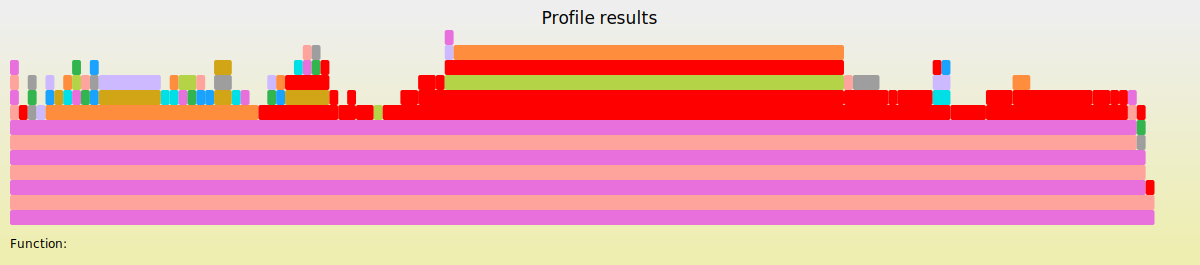

In [128]:
# Pkg.add("ProfileView")
using ProfileView
ProfileView.view()

In [129]:
Profile.print()

129 ./task.jl:335; (::IJulia.##14#17)()
 129 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  128 ...rc/execute_request.jl:154; execute_request(::ZMQ.Socket, ::...
   128 .../Compat/src/Compat.jl:174; include_string(::Module, ::Strin...
    128 ./loading.jl:522; include_string(::String, ::String)
     1   ./<missing>:?; anonymous
      1 ./profile.jl:23; macro expansion
       1 ./In[115]:66; lbfgs!(::#rosenbrock, ::Array{F...
        1 ./broadcast.jl:455; broadcast
         1 ./broadcast.jl:316; broadcast_c
          1 ./broadcast.jl:268; broadcast_t(::Function, ::Typ...
     127 ./In[45]:15; benchmark(::Int64, ::Function)
      127 ./profile.jl:23; macro expansion
       127 ./In[41]:4; loop_bfgs(::Int64, ::Function)
        1  ./In[23]:22; lbfgs!(::#rosenbrock, ::Array{...
         1 ./In[24]:22; strongwolfe(::#rosenbrock, ::A...
          1 ./In[25]:2; zoom(::Function, ::Array{Float...
           1 ./In[25]:9; zoom(::#rosenbrock, ::Array{F...
        1  ./In[23]:23; lbfgs!(::

In [130]:
function loop_bfgs(range = 100, fun = rosenbrock)
    
    for i = 1:range
        lbfgs!(fun,x0,100,2)
    end
    
end

loop_bfgs (generic function with 3 methods)

In [131]:
# Reference: https://thirld.com/blog/2015/05/30/julia-profiling-cheat-sheet/

function benchmark(range = 100, fun = rosenbrock)
    seed = 42
    
    # force compilation
    srand(seed)
    @time lbfgs!(fun,x0,100,2)

    # profile
    srand(seed)
    Profile.init(delay=0.001)
    Profile.clear()
#     clear_malloc_data()
    @profile loop_bfgs(range, fun)

    # store output
    r = Profile.retrieve()
    f = open("profile.bin", "w")
    serialize(f, r)
    close(f)
end

benchmark (generic function with 3 methods)

  0.001341 seconds (6.16 k allocations: 313.594 KiB)


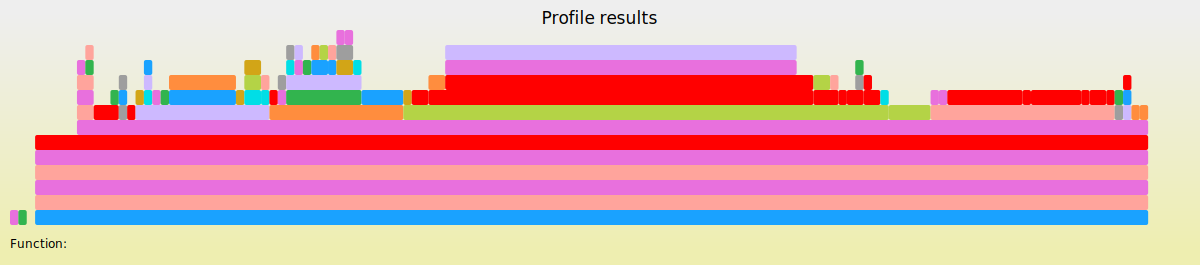

In [132]:
range = 100
fun = rosenbrock
benchmark(range, fun)

using ProfileView
f = open("profile.bin")
r = deserialize(f);
ProfileView.view(r[1], lidict=r[2])

In [133]:
x0 = [-1.948, -2.048]
include("testfns.jl")

x1, f1, k=lbfgs!(rosenbrock,x0,100,2)

([1.0, 1.0], 2.344134811351014e-22, 33, [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0])

# Results

In [135]:
include("testfns.jl")
fun = rosenbrock
m = 2
x0_opt = [1.,1.]
tol = 1e-8
x0 = [0.75, 2.0]
x1, f1, k, pos=lbfgs!(fun, x0, 100, m); 
pos = pos[1:(k+1), :]; 
bool = false
if (x1[2] - x0_opt[2]) < tol && (x1[1] - x0_opt[1]) < tol
    bool = true 
end

println("\n===============================================================\nResults:\n===============================================================")
println("* Algorithm: L-BFGS w/ StrongWolfe - own implementation")
println(" * Function: $(fun)")
println(" * Starting Point: $(x0)")
println(" * Minimizer: [$(x1[1]), $(x1[2])] ")
println(" * Minimum: $(f1)")
println(" * Iterations: $(k)")
println(" * Convergence to within $(tol): $(bool)")


Results:
* Algorithm: L-BFGS w/ StrongWolfe - own implementation
 * Function: rosenbrock
 * Starting Point: [0.75, 2.0]
 * Minimizer: [0.9999999984053014, 0.9999999970779291] 
 * Minimum: 9.689397192584973e-18
 * Iterations: 30
 * Convergence to within 1.0e-8: true


## Compile Average Results

In [18]:
funs = [rosenbrock, himmelblau, booth]
n_x0 = 1000
maxIt = 100
results_mat = zeros(3,5)
cnt = 1
println("\n=========================================================\nResults: \n=========================================================")
# compare different test functions
for fun in funs
    println("\nfunction: $(fun)")
    
    # compare different numbers of stored update vectors
    for m = 2:2:10
        k_tot = 0 
        
        for i = 1:n_x0
            x0 = rand(2); 
            x1, f1, k, pos = lbfgs!(fun, x0, maxIt, m)
            k_tot += k
        end
        s = convert(Int64, m/2)
        println(s)
        results_mat[cnt, s] = k_tot/n_x0
        println("Average number of iterations for $(fun) and m = $m, averaged over $(n_x0) iterations: $(k_tot/n_x0)")
    end
    cnt += 1
end

results_mat


Results: 

function: rosenbrock
1
Average number of iterations for rosenbrock and m = 2, averaged over 1000 iterations: 28.704
2
Average number of iterations for rosenbrock and m = 4, averaged over 1000 iterations: 47.382
3
Average number of iterations for rosenbrock and m = 6, averaged over 1000 iterations: 70.861
4
Average number of iterations for rosenbrock and m = 8, averaged over 1000 iterations: 75.488
5
Average number of iterations for rosenbrock and m = 10, averaged over 1000 iterations: 75.616

function: himmelblau
1
Average number of iterations for himmelblau and m = 2, averaged over 1000 iterations: 45.228
2
Average number of iterations for himmelblau and m = 4, averaged over 1000 iterations: 54.042
3
Average number of iterations for himmelblau and m = 6, averaged over 1000 iterations: 96.147
4
Average number of iterations for himmelblau and m = 8, averaged over 1000 iterations: 66.996
5
Average number of iterations for himmelblau and m = 10, averaged over 1000 iterations: 

3×5 Array{Float64,2}:
 28.704  47.382  70.861  75.488  75.616
 45.228  54.042  96.147  66.996  24.527
 24.487  31.801  45.039  18.194   9.74 

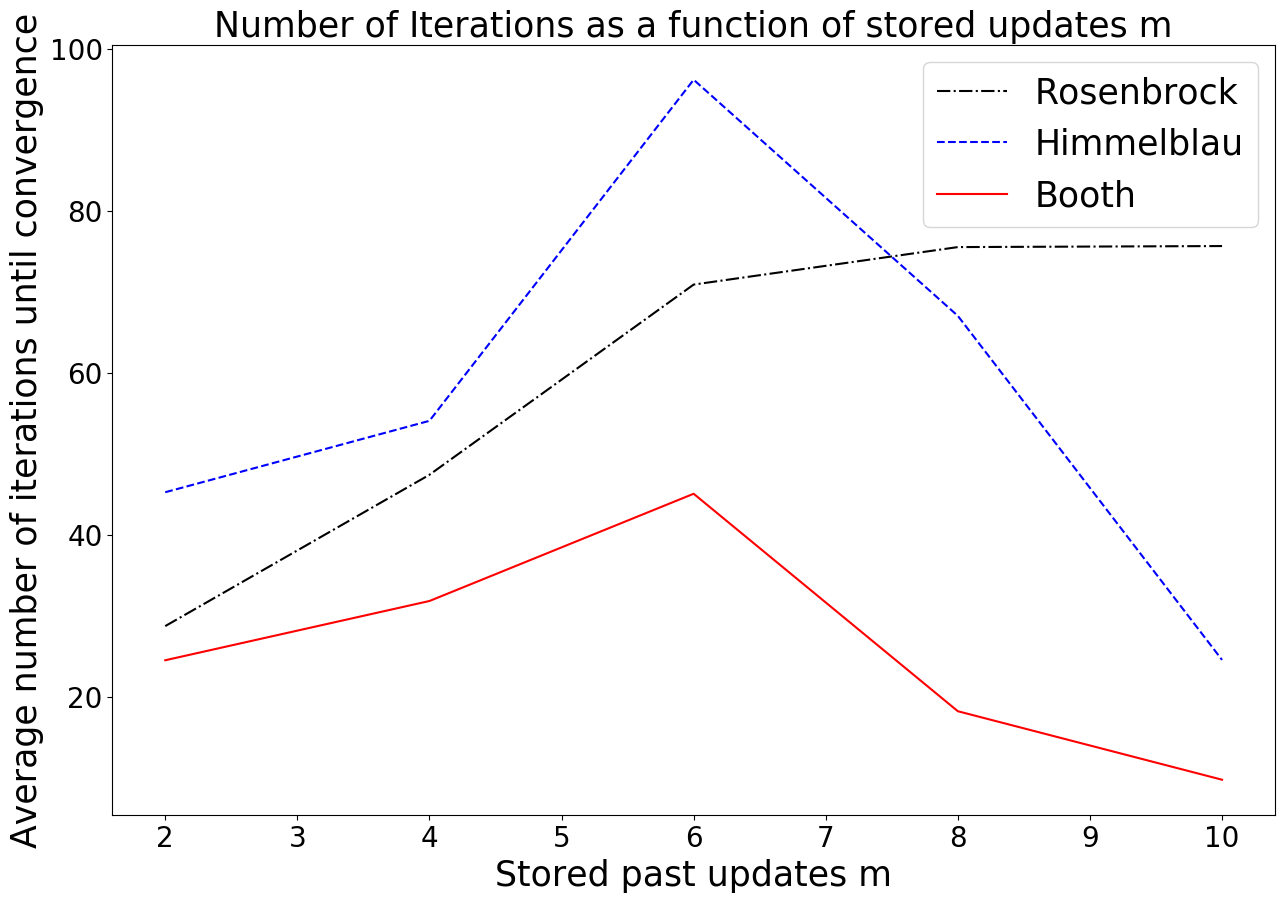

In [39]:
using PyPlot
m_vec = collect(2:2:10)

figure(figsize=(15, 10))
plot(m_vec, results_mat[1, :], "k-.", m_vec, results_mat[2, :], "b--", m_vec, results_mat[3, :], "r-")
tick_params(axis="both", which="major", labelsize=20)
title("Number of Iterations as a function of stored updates m", fontsize=25)
xlabel("Stored past updates m", fontsize=25)
ylabel("Average number of iterations until convergence", fontsize=25)
legend(["Rosenbrock", "Himmelblau", "Booth"], loc="upper right", fontsize=25)
savefig("iterations")



# Memory

In [10]:
x0 = [0.75, 2.0]
funs = [rosenbrock, himmelblau, booth]
mem_tot = 0 
for fun in funs
    mem = @allocated lbfgs!(rosenbrock, x0, 100, 2)
    mem_tot += mem
    println("Number of bytes allocated for $(fun): $(mem_tot)")
end

Number of bytes allocated for rosenbrock: 2003919
Number of bytes allocated for himmelblau: 2320943
Number of bytes allocated for booth: 2637967


In [15]:
funs = [rosenbrock, himmelblau, booth]
n_x0 = 1000
maxIt = 100
results_mat_mem = zeros(3,5)
cnt = 1
println("\n=========================================================\nResults: \n=========================================================")

# compare different test functions
for fun in funs
    println("\n")
    
    # compare different numbers of stored update vectors
    for m = 2:2:10
        mem_tot = 0 
        
        for i = 1:n_x0
            x0 = rand(2); 
            mem_throw = @allocated lbfgs!(fun, x0, maxIt, m)
            mem = @allocated lbfgs!(fun, x0, maxIt, m)
            mem_tot += mem
        end
        
        s = convert(Int64, m/2)
        println(s)
        results_mat_mem[cnt, s] = mem_tot/(n_x0*1000)
        println("Average memory in [kB] allocated for $(fun) and m = $m, averaged over $(n_x0) iterations: $(mem_tot/(n_x0*1000))")
    end
    cnt += 1
end

results_mat_mem



Results: 


1
Average memory in [kB] allocated for rosenbrock and m = 2, averaged over 1000 iterations: 296.091824
2
Average memory in [kB] allocated for rosenbrock and m = 4, averaged over 1000 iterations: 1122.8536
3
Average memory in [kB] allocated for rosenbrock and m = 6, averaged over 1000 iterations: 3124.583408
4
Average memory in [kB] allocated for rosenbrock and m = 8, averaged over 1000 iterations: 4059.208912
5
Average memory in [kB] allocated for rosenbrock and m = 10, averaged over 1000 iterations: 4259.456848


1
Average memory in [kB] allocated for himmelblau and m = 2, averaged over 1000 iterations: 519.037056
2
Average memory in [kB] allocated for himmelblau and m = 4, averaged over 1000 iterations: 1601.950432
3
Average memory in [kB] allocated for himmelblau and m = 6, averaged over 1000 iterations: 5465.780048
4
Average memory in [kB] allocated for himmelblau and m = 8, averaged over 1000 iterations: 4382.801248
5
Average memory in [kB] allocated for himmelblau an

3×5 Array{Float64,2}:
 296.092  1122.85   3124.58   4059.21   4259.46 
 519.037  1601.95   5465.78   4382.8    1343.46 
 223.86    481.142   875.126   405.421   164.207

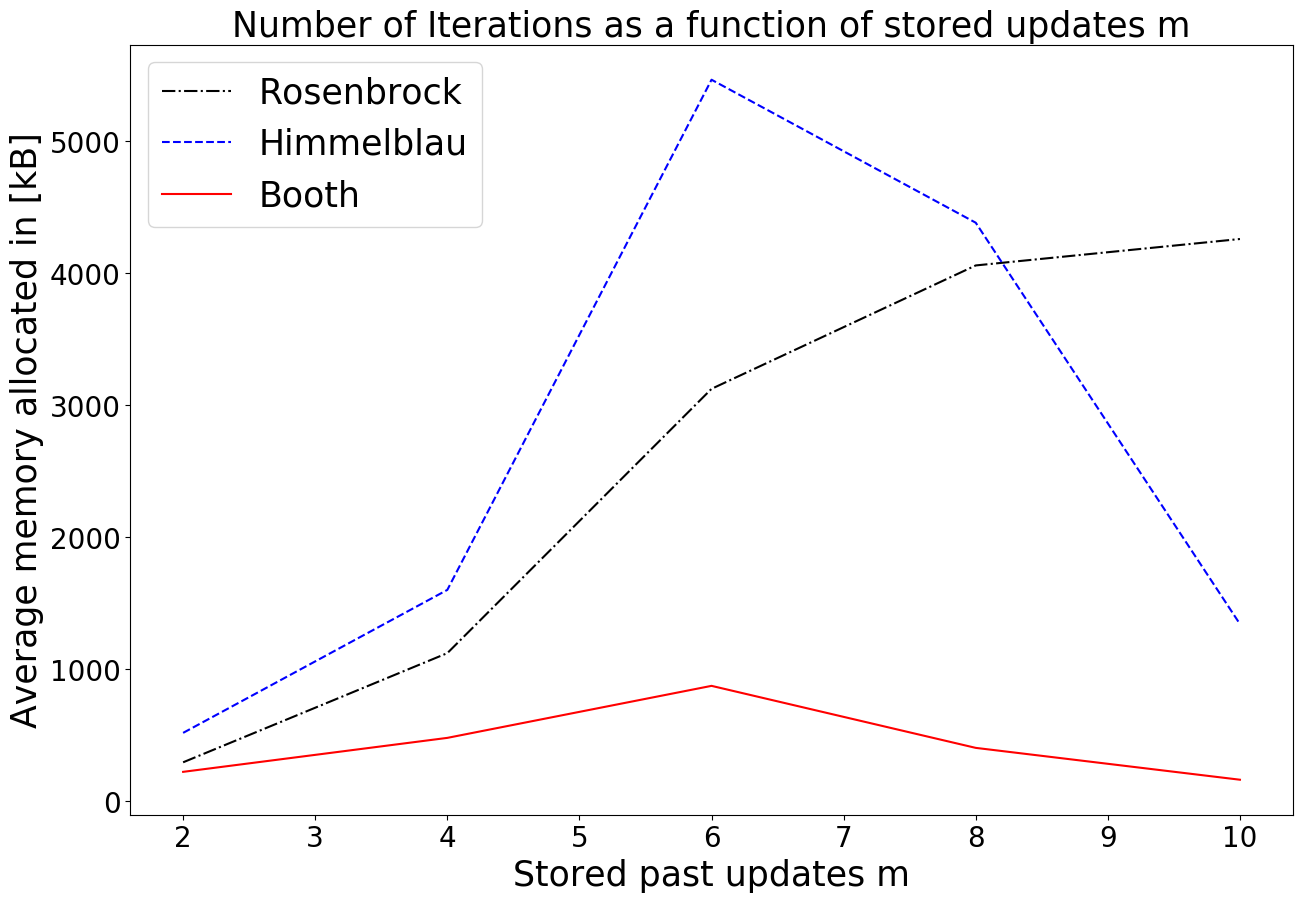

In [19]:
using PyPlot

m_vec = collect(2:2:10)

figure(figsize=(15, 10))
plot(m_vec, results_mat_mem[1, :], "k-.", m_vec, results_mat_mem[2, :], "b--", m_vec, results_mat_mem[3, :], "r-")
tick_params(axis="both", which="major", labelsize=20)
title("Number of Iterations as a function of stored updates m", fontsize=25)
xlabel("Stored past updates m", fontsize=25)
ylabel("Average memory allocated in [kB]", fontsize=25)
legend(["Rosenbrock", "Himmelblau", "Booth"], loc="upper left", fontsize=25)
savefig("memory")